Load all the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
from math import sqrt
from pylab import rcParams

In [2]:
#IMPORT DATA
btc_data = pd.read_csv('content/BTC2019_2024.csv',index_col='date')
bnb_data = pd.read_csv('content/BNB2019_2024.csv',index_col='date')
eth_data = pd.read_csv('content/ETH2019_2024.csv',index_col='date')

btc_data = btc_data.dropna()
bnb_data = bnb_data.dropna()
eth_data = eth_data.dropna()

print('Shape of bitcoin data', btc_data.shape)
print('Shape of binance data', bnb_data.shape)
print('Shape of ethereum data', eth_data.shape)


Shape of bitcoin data (1815, 5)
Shape of binance data (1815, 5)
Shape of ethereum data (1815, 5)


In [41]:
btc_data.head()

,Open,High,Low,Close,Volume
date,,,,,
2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,7661247975
2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,7578786076
2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,7253558152
2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,9029175788
2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,10174126415


In [42]:
bnb_data.head()

,Open,High,Low,Close,Volume
date,,,,,
2019-03-01,10.356931,11.607489,10.325634,11.393217,117838677
2019-03-02,11.384693,11.915753,10.960816,11.869744,120807894
2019-03-03,11.845305,11.964979,11.352064,11.537903,89868246
2019-03-04,11.538013,11.599405,11.070543,11.545945,89421231
2019-03-05,11.520388,13.841443,11.520388,13.811967,237026335


In [43]:
eth_data.head()

,Open,High,Low,Close,Volume
date,,,,,
2019-03-01,136.836243,138.995270,136.434784,136.443619,3756124824
2019-03-02,136.350082,137.184799,132.436386,134.206955,3747176425
2019-03-03,134.786118,135.849289,131.328857,132.249420,3454374053
2019-03-04,132.157883,132.729141,125.402702,127.774124,4008171341
2019-03-05,127.792953,138.229980,126.735298,137.822388,4764849990


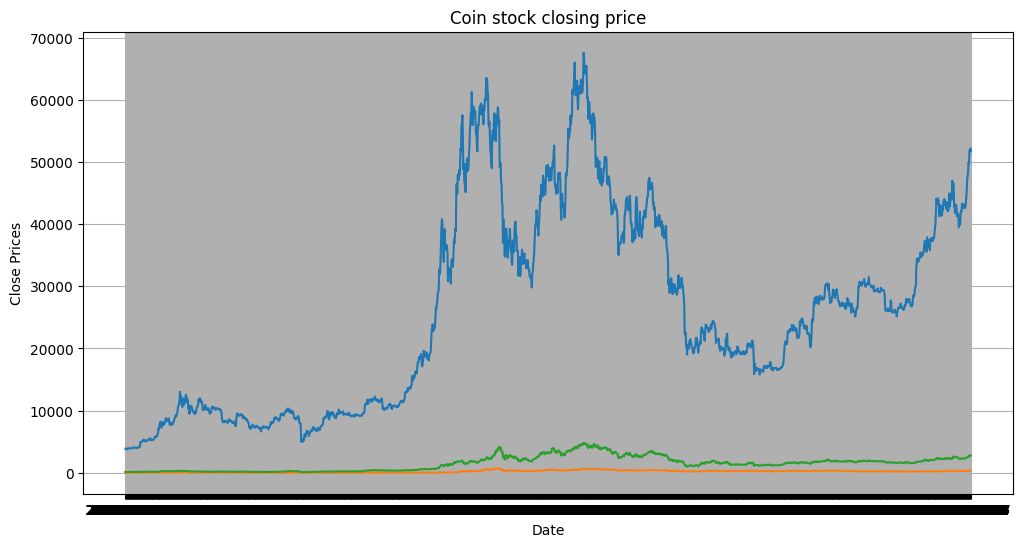

In [44]:
#Plot "Close" price of btc, bnb, and eth.
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(btc_data['Close'])
plt.plot(bnb_data['Close'])
plt.plot(eth_data['Close'])
plt.title('Coin stock closing price')
plt.show()

Only using 'Close' for predicting

In [3]:
df_btc = btc_data['Close']
df_bnb = bnb_data['Close']
df_eth = eth_data['Close']

Test for staionarity

In [4]:
def test_stationarity(timeseries):
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [47]:
#Test bitcoin dataset
test_stationarity(btc_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.383119
p-value                           0.590342
#Lags Used                        9.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [48]:
#Test Binance Dataset
test_stationarity(bnb_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.777350
p-value                           0.391763
#Lags Used                       25.000000
Number of Observations Used    1789.000000
Critical Value (1%)              -3.434011
Critical Value (5%)              -2.863157
Critical Value (10%)             -2.567631
dtype: float64


In [49]:
#Test Ethereum Dataset
test_stationarity(eth_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.416200
p-value                           0.574486
#Lags Used                       17.000000
Number of Observations Used    1797.000000
Critical Value (1%)              -3.433994
Critical Value (5%)              -2.863150
Critical Value (10%)             -2.567627
dtype: float64


Eliminate trend

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


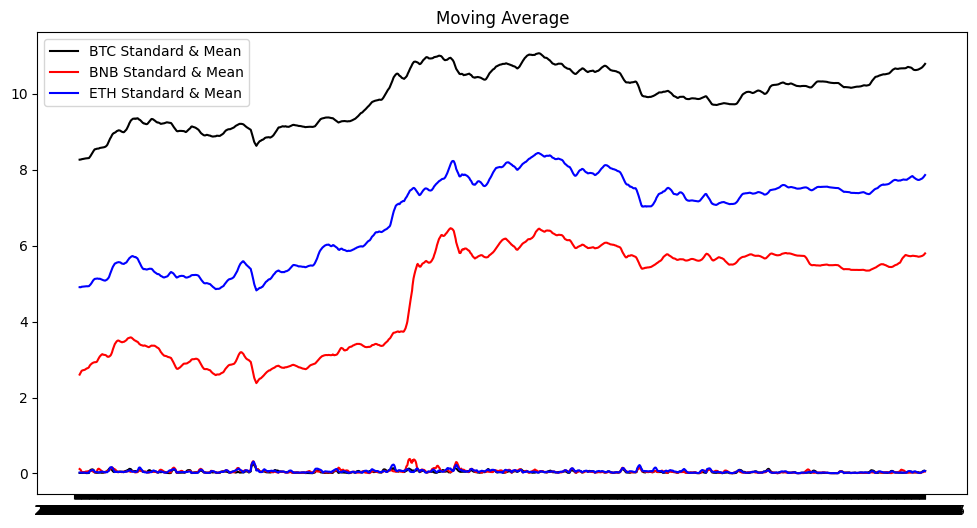

In [5]:
rcParams['figure.figsize'] = 12, 6

df_log_btc = np.log(df_btc)
df_log_bnb = np.log(df_bnb)
df_log_eth = np.log(df_eth)

moving_avg_btc = df_log_btc.rolling(12).mean()
moving_avg_bnb = df_log_bnb.rolling(12).mean()
moving_avg_eth = df_log_eth.rolling(12).mean()

std_dev_btc = df_log_btc.rolling(12).std()
std_dev_bnb = df_log_bnb.rolling(12).std()
std_dev_eth = df_log_eth.rolling(12).std()

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev_btc, color ="black", label = "BTC Standard & Mean")
plt.plot(std_dev_bnb, color ="red", label = "BNB Standard & Mean")
plt.plot(std_dev_eth, color ="blue", label = "ETH Standard & Mean")
plt.plot(moving_avg_btc, color="black")
plt.plot(moving_avg_bnb, color="red")
plt.plot(moving_avg_eth, color="blue")
plt.legend()
plt.show()

Get the p,d,q by using Auto Arima

In [51]:
#BITCOIN
stepwise_fit = auto_arima(df_log_btc, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6963.600, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6962.753, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6965.128, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6964.809, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6961.803, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6965.640, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6963.641, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6963.643, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6966.847, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6963.381, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6965.369, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6965.709, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.741 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3487.423
Date:                Thu, 20 Jun 2024   AIC                          -6966.847
Time:                        22:49:56   BIC                          -6944.834
Sample:                    03-01-2019   HQIC                         -6958.724
                         - 02-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      1.685      0.092      -0.000       0.005
ar.L1         -0.6986      0.147     -4.757      0.000      -0.986      -0.411
ma.L1          0.6508      0.155      4.187      0.000       0.346       0.955
sigma2         0.0013   1.36e-05     92.161      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             27937.07
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for bitcoin dataset as 1, 1 and 1 respectively.

In [52]:
#BINANCE
stepwise_fit = auto_arima(df_log_bnb, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5878.211, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5854.318, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5861.921, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5860.394, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5853.499, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5874.286, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5873.468, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5874.655, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5875.421, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5875.342, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5874.230, Time=1.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5871.465, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5873.468, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5876.833, Time=0.26 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(2, 1, 2)   Log Likelihood                2945.105
Date:                Thu, 20 Jun 2024   AIC                          -5878.211
Time:                        22:50:03   BIC                          -5845.191
Sample:                    03-01-2019   HQIC                         -5866.027
                         - 02-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      1.004      0.315      -0.000       0.002
ar.L1          0.0611      0.086      0.711      0.477      -0.107       0.229
ar.L2          0.6647      0.088      7.587      0.000       0.493       0.836
ma.L1         -0.1134      0.093     -1.223      0.221      -0.295       0.068
ma.L2         -0.5720      0.093     -6.150      0.000      -0.754      -0.390
sigma2         0.0023   2.47e-05     92.240      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             38074.25
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for binance dataset as 2, 1 and 2 respectively.

In [53]:
#ETHEREUM
stepwise_fit = auto_arima(df_log_eth, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6113.984, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6106.230, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6111.993, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6111.315, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6105.748, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6115.700, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6113.185, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6117.658, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6111.592, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6113.586, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6116.987, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.086 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3062.829
Date:                Thu, 20 Jun 2024   AIC                          -6117.658
Time:                        22:50:06   BIC                          -6095.645
Sample:                    03-01-2019   HQIC                         -6109.535
                         - 02-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.002      1.543      0.123      -0.001       0.007
ar.L1         -0.7944      0.080     -9.973      0.000      -0.951      -0.638
ma.L1          0.7383      0.089      8.297      0.000       0.564       0.913
sigma2         0.0020   2.37e-05     84.467      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             20080.48
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for ethereum dataset as 1, 1 and 1 respectively.

Split data into train and test set

In [6]:
train_ratio = 0.8

In [7]:
# BITCOIN 7:3 SPLIT
train_btc = df_log_btc[:int(len(df_log_btc)*train_ratio)]
test_btc = df_log_btc[int(len(df_log_btc)*train_ratio):]
print(train_btc.shape, test_btc.shape)

(1452,) (363,)


In [8]:
# BINANCE 7:3 SPLIT
train_bnb = df_log_bnb[:int(len(df_log_bnb)*train_ratio)]
test_bnb = df_log_bnb[int(len(df_log_bnb)*train_ratio):]
print(train_bnb.shape, test_bnb.shape)

(1452,) (363,)


In [9]:
# ETHEREUM 7:3 SPLIT
train_eth = df_log_eth[:int(len(df_log_eth)*train_ratio)]
test_eth = df_log_eth[int(len(df_log_eth)*train_ratio):]
print(train_eth.shape, test_eth.shape)

(1452,) (363,)


# Modeling

## BTC

In [10]:
#BITCOIN
model_btc = ARIMA(train_btc, order=(1,1,1))
model_btc = model_btc.fit()
model_btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1452
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2687.947
Date:                Fri, 21 Jun 2024   AIC                          -5369.895
Time:                        22:54:30   BIC                          -5354.055
Sample:                    03-01-2019   HQIC                         -5363.984
                         - 02-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5502      0.246     -2.236      0.025      -1.032      -0.068
ma.L1          0.4950      0.255      1.941      0.052      -0.005       0.995
sigma2         0.0014   1.74e-05     82.713      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             19442.10
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
#Predict Results
start = len(train_btc)
end = len(train_btc) + len(test_btc) -1
pred = model_btc.predict(start=start, end=end)
print(pred)

2023-02-20    10.099170
2023-02-21    10.099279
2023-02-22    10.099219
2023-02-23    10.099252
2023-02-24    10.099234
                ...    
2024-02-13    10.099240
2024-02-14    10.099240
2024-02-15    10.099240
2024-02-16    10.099240
2024-02-17    10.099240
Freq: D, Name: predicted_mean, Length: 363, dtype: float64


In [12]:
#Report Performance
rmse_btc = root_mean_squared_error(np.exp(test_btc), np.exp(pred))
print('RMSE: '+str(rmse_btc.round(3)))

mse_btc = mean_squared_error(np.exp(test_btc), np.exp(pred))
print('MSE: '+str(mse_btc.round(3)))

mape_btc = mean_absolute_percentage_error(np.exp(test_btc), np.exp(pred))
print('MAPE: '+str(mape_btc.round(3)))

RMSE: 10384.636
MSE: 107840669.08
MAPE: 0.214


In [61]:
model_btc_2 = ARIMA(df_log_btc, order=(1,1,5))
model_btc_2 = model_btc_2.fit()
btc_data.tail()

,Open,High,Low,Close,Volume
date,,,,,
2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,35593051468
2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,39105608050
2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,38564360533
2024-02-16,51937.726563,52537.968750,51641.367188,52160.203125,28180567298
2024-02-17,52161.675781,52180.582031,51558.039063,51724.253906,22865082368


In [62]:
# index for future dates
index_future_dates = pd.RangeIndex(start=len(btc_data), stop=len(btc_data)+91, step=1)
pred_btc = model_btc_2.predict(start=len(btc_data), end=len(btc_data)+90).rename('ARIMA prediction')
pred_btc.index = index_future_dates

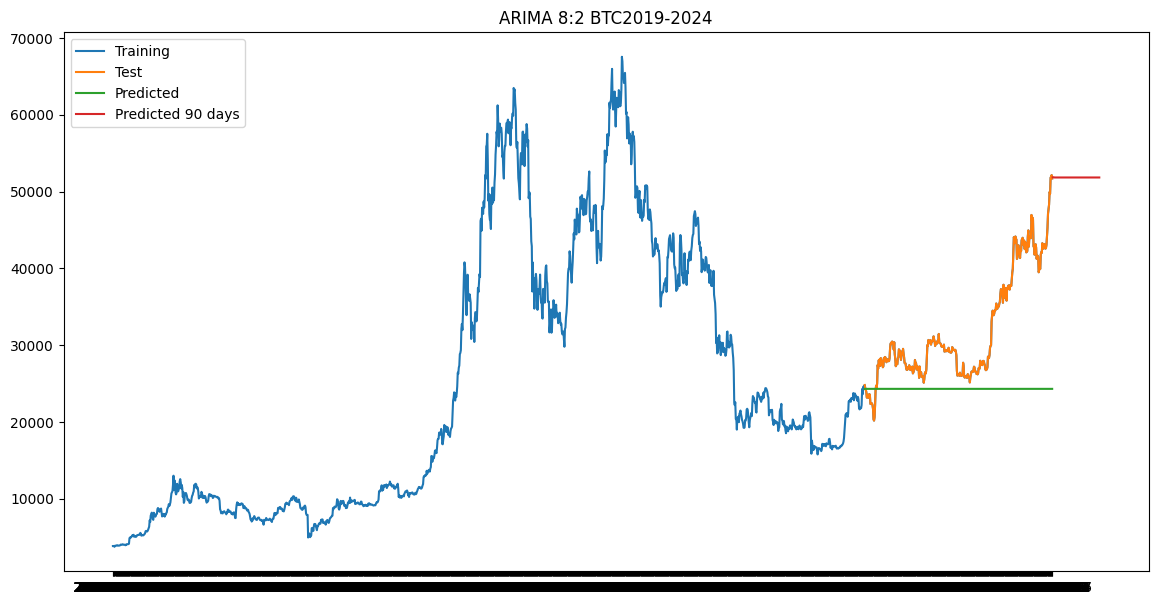

In [63]:
# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(np.exp(df_log_btc), label='Training')
plt.plot(test_btc.index, np.exp(test_btc), label='Test')
plt.plot(test_btc.index, np.exp(pred), label='Predicted')
plt.plot(pred_btc.index, np.exp(pred_btc), label='Predicted 90 days')
plt.title('ARIMA 8:2 BTC2019-2024')
plt.legend(loc='upper left')
plt.show()

## BNB

In [13]:
#BINANCE
model_bnb = ARIMA(train_bnb, order=(2,1,2))
model_bnb = model_bnb.fit()
model_bnb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1452
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2227.634
Date:                Fri, 21 Jun 2024   AIC                          -4445.268
Time:                        22:55:26   BIC                          -4418.868
Sample:                    03-01-2019   HQIC                         -4435.416
                         - 02-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1976      0.069      2.870      0.004       0.063       0.332
ar.L2          0.7161      0.063     11.402      0.000       0.593       0.839
ma.L1         -0.2619      0.077     -3.423      0.001      -0.412      -0.112
ma.L2         -0.6157      0.071     -8.641      0.000      -0.755      -0.476
sigma2         0.0027   3.48e-05     78.071      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             21787.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
#Predict Results
start = len(train_btc)
end = len(train_btc) + len(test_btc) -1
pred = model_bnb.predict(start=start, end=end)
print(pred)

2023-02-20    5.742275
2023-02-21    5.743080
2023-02-22    5.742865
2023-02-23    5.743399
2023-02-24    5.743350
                ...   
2024-02-13    5.747263
2024-02-14    5.747263
2024-02-15    5.747263
2024-02-16    5.747263
2024-02-17    5.747263
Freq: D, Name: predicted_mean, Length: 363, dtype: float64


In [16]:
#Report Performance
rmse_bnb = root_mean_squared_error(np.exp(test_bnb), np.exp(pred))
print('RMSE: '+str(rmse_bnb.round(3)))

mse_bnb = mean_squared_error(np.exp(test_bnb), np.exp(pred))
print('MSE: '+str(mse_bnb.round(3)))

mape_bnb = mean_absolute_percentage_error(np.exp(test_bnb), np.exp(pred))
print('MAPE: '+str(mape_bnb.round(3)))

RMSE: 62.409
MSE: 3894.94
MAPE: 0.213


In [67]:
model_bnb_2 = ARIMA(df_log_bnb, order=(2,1,2))
model_bnb_2 = model_bnb_2.fit()
btc_data.tail()

,Open,High,Low,Close,Volume
date,,,,,
2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,35593051468
2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,39105608050
2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,38564360533
2024-02-16,51937.726563,52537.968750,51641.367188,52160.203125,28180567298
2024-02-17,52161.675781,52180.582031,51558.039063,51724.253906,22865082368


In [68]:
index_future_dates = pd.RangeIndex(start=len(bnb_data), stop=len(bnb_data)+91, step=1)
pred_bnb = model_bnb_2.predict(start=len(bnb_data), end=len(bnb_data)+90).rename('ARIMA prediction')
pred_bnb.index = index_future_dates
print(pred_bnb)

1815    5.879803
1816    5.880450
1817    5.882111
1818    5.882551
1819    5.883410
          ...   
1901    5.885052
1902    5.885052
1903    5.885052
1904    5.885052
1905    5.885052
Name: ARIMA prediction, Length: 91, dtype: float64


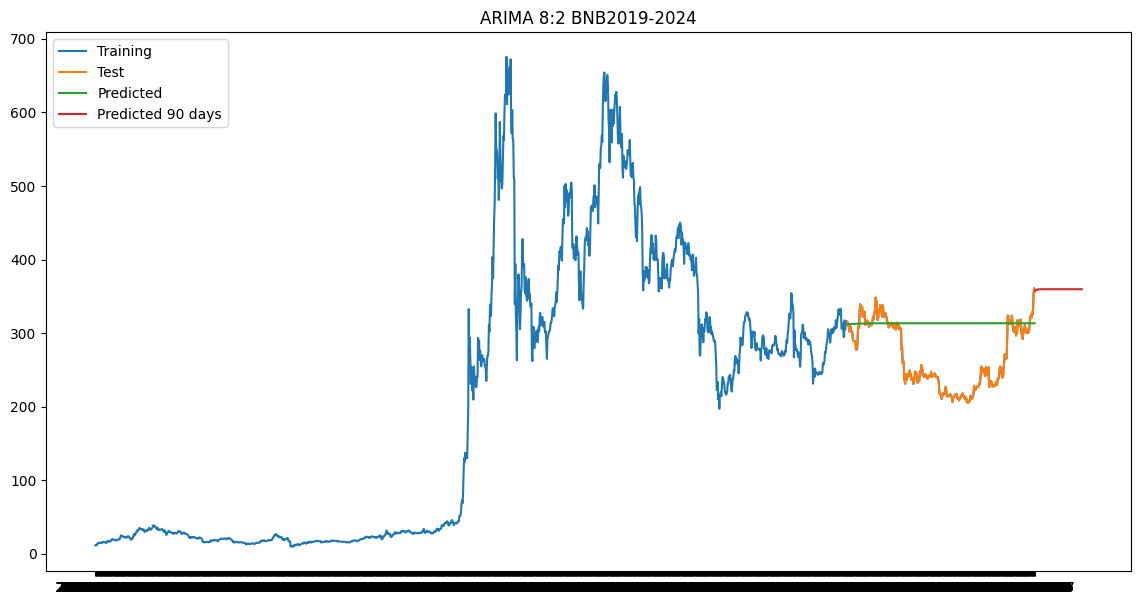

In [69]:
# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(np.exp(df_log_bnb), label='Training')
plt.plot(test_bnb.index, np.exp(test_bnb), label='Test')
plt.plot(test_bnb.index, np.exp(pred), label='Predicted')
plt.plot(pred_bnb.index, np.exp(pred_bnb), label='Predicted 90 days')
plt.title('ARIMA 8:2 BNB2019-2024')
plt.legend(loc='upper left')
plt.show()

## ETH

In [17]:
#ETHEREUM
model_eth = ARIMA(train_eth, order=(1,1,1))
model_eth = model_eth.fit()
model_eth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1452
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2330.756
Date:                Fri, 21 Jun 2024   AIC                          -4655.512
Time:                        22:56:05   BIC                          -4639.672
Sample:                    03-01-2019   HQIC                         -4649.601
                         - 02-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8109      0.088     -9.196      0.000      -0.984      -0.638
ma.L1          0.7562      0.099      7.635      0.000       0.562       0.950
sigma2         0.0024   3.14e-05     75.011      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12496.57
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -1.31
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
#Predict Results
start = len(train_eth)
end = len(train_eth) + len(test_eth) -1
pred = model_eth.predict(start=start, end=end)
print(pred)

2023-02-20    7.425181
2023-02-21    7.426983
2023-02-22    7.425522
2023-02-23    7.426707
2023-02-24    7.425746
                ...   
2024-02-13    7.426176
2024-02-14    7.426176
2024-02-15    7.426176
2024-02-16    7.426176
2024-02-17    7.426176
Freq: D, Name: predicted_mean, Length: 363, dtype: float64


In [19]:
#Report Performance
rmse_eth = root_mean_squared_error(np.exp(test_eth), np.exp(pred))
print('RMSE: '+str(rmse_eth.round(3)))

mse_eth = mean_squared_error(np.exp(test_eth), np.exp(pred))
print('MSE: '+str(mse_eth.round(3)))

mape_eth = mean_absolute_percentage_error(np.exp(test_eth), np.exp(pred))
print('MAPE: '+str(mape_eth.round(3)))

RMSE: 363.658
MSE: 132247.113
MAPE: 0.126


In [73]:
model_eth_2 = ARIMA(df_log_eth, order=(2,1,2))
model_eth_2 = model_eth_2.fit()
btc_data.tail()

,Open,High,Low,Close,Volume
date,,,,,
2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,35593051468
2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,39105608050
2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,38564360533
2024-02-16,51937.726563,52537.968750,51641.367188,52160.203125,28180567298
2024-02-17,52161.675781,52180.582031,51558.039063,51724.253906,22865082368


In [74]:
index_future_dates = pd.RangeIndex(start=len(eth_data), stop=len(eth_data)+91, step=1)
pred_eth = model_eth_2.predict(start=len(eth_data), end=len(eth_data)+90).rename('ARIMA prediction')
pred_eth.index = index_future_dates
print(pred_eth)

1815    7.933058
1816    7.932899
1817    7.934760
1818    7.934911
1819    7.936287
          ...   
1901    7.946381
1902    7.946382
1903    7.946384
1904    7.946385
1905    7.946386
Name: ARIMA prediction, Length: 91, dtype: float64


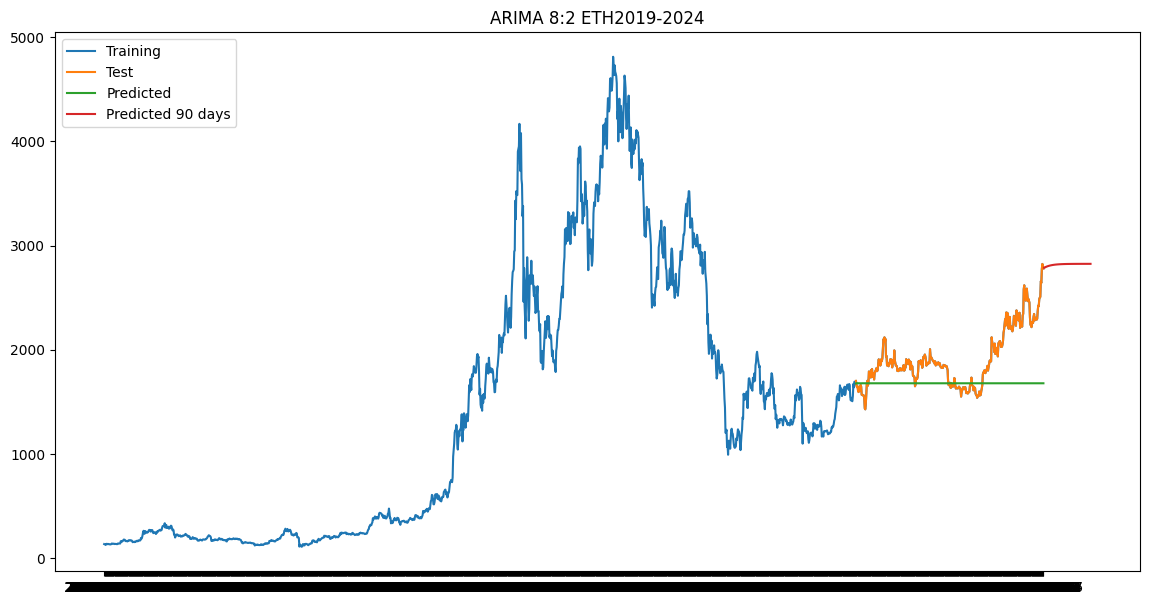

In [75]:
# Plotting the results
plt.figure(figsize=(14,7))
plt.plot(np.exp(df_log_eth), label='Training')
plt.plot(test_eth.index, np.exp(test_eth), label='Test')
plt.plot(test_eth.index, np.exp(pred), label='Predicted')
plt.plot(pred_eth.index, np.exp(pred_eth), label='Predicted 90 days')
plt.title('ARIMA 8:2 ETH2019-2024')
plt.legend(loc='upper left')
plt.show()